# SFC17 User Tool


### Pedro Beirao

In [1]:
%reload_ext autoreload
%autoreload 2
#%pdb on
%matplotlib notebook

In [2]:
import sys
sys.path.append('/home/devvm/sfc17')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import interp, arange
from sfc17 import models
from sfc17 import tools
from sfc17 import validation
from sfc17 import ff_decomposition

## Overview

The SFC17 model is a tool to model SFC curves using a combination of robust linear regression and gaussian processes. It allows you to set many parameters: engine numbers, power range and step size, and allows separate modeling of different fuel types. 

The SFC17 model consists of two stages:

- Robust linear model

- Non-linear, non-parametric model that fits residuals from the purely linear model.

The data is cleaned and rebinned to 5 min intervals, and then one or 2 SFC models are fitted, depending on wehter we have 1 or 2 fuel types in the data.

## The SFC 17 package

The SFC17 package is structured in 3 folders: 
- "Models": contains the implementation of the core regression and GP modeling functions
- "Tools": contains cleaning and rebinning, fuel type split, engine info, json conversion, etc.
- "Validation": contains validation plot functions.

Giving a vessel name, let's use the engine database to extract information from all engines:

In [3]:
ship = '1010-005'
ed, gd = tools.engine_info(ship)

Engine info available for:  ['engine.main.1' 'engine.main.2' 'engine.main.3' 'engine.main.4'
 'engine.main.5' 'engine.main.6']
              name.manufacturer name.model
engine.main.1          Wartsila   12ZAV40S
engine.main.2          Wartsila   12ZAV40S
engine.main.3          Wartsila   12ZAV40S
engine.main.4          Wartsila   12ZAV40S
engine.main.5          Wartsila    8ZAL40S
engine.main.6          Wartsila    8ZAL40S                     power.mcr  ratio.power.max  ratio.power.min
generator.diesel.1       7.92             0.77              0.4
generator.diesel.2       7.92             0.77              0.4
generator.diesel.3       7.92             0.77              0.4
generator.diesel.4       7.92             0.77              0.4
generator.diesel.5       5.28             0.77              0.4
generator.diesel.6       5.28             0.77              0.4
More info in  [ 'http://www.sea-web.com/authenticated/authenticated_handler.aspx?control=shipovw&qs=carnival%20fascination&L

/home/devvm/src/venv/enipy2016-py35/lib/python3.5/site-packages/pandas/indexes/api.py:37: RuntimeWarning: unorderable types: str() > int(), sort order is undefined for incomparable objects
  union = _union_indexes(indexes)
/home/devvm/src/venv/enipy2016-py35/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning: unorderable types: str() > int(), sort order is undefined for incomparable objects
  result = result.union(other)


In [4]:
tools.variable_info(ship)

Mass flow rate available.
angle.rotation@inclinometer.1, angle.rotation@inclinometer.2, angle.trim, angle.wind.relative, angle.wind.true, angle@rudder.ps, angle@rudder.sb, angle@stabilizer.ps, angle@stabilizer.sb, aog, area.drag, area.sea, area.sea.rule, area@voyage.phase.area, area@voyage.phase.area.rule, atw, automation:draft@aft, automation:draft@fore, automation:energy.counter@generator.diesel.1, automation:energy.counter@generator.diesel.2, automation:energy.counter@generator.diesel.3, automation:energy.counter@generator.diesel.4, automation:energy.counter@generator.diesel.5, automation:energy.counter@generator.diesel.6, automation:list, automation:mass.fuel.counter@boiler.1, automation:mass.fuel.counter@boiler.2, automation:mass.fuel.counter@engine.main.1, automation:mass.fuel.counter@engine.main.2, automation:mass.fuel.counter@engine.main.3, automation:mass.fuel.counter@engine.main.4, automation:mass.fuel.counter@engine.main.5, automation:mass.fuel.counter@engine.main.6, automat

## Preparing and validating data

The 'prepare' tool outputs a dataframe with clean fuel flow and power data of all the selected engines. Next we set the parameters necessary to use it:

   - The beginning and end of the period for data extraction from the HDF5 REST database;
   - The numbers of the engines for which you would like to extract data;
   - If you want to explicitly use the "SFOC box" measurements, use "sfoc_plc = 1"; 
   - If mass fuel flow measurements are absent, and you want to calculate the mass fuel flow using decomposed volume fuel flow measurements, enable 'decomp = 1'. Attention: This feature is still very experimental and now it only works in ships with 6 engines with available fuel density data.

In [5]:
begin_date = '2016-07-01'
end_date = '2016-07-31'
engines = ['1','2','3','4','5','6']
sfoc_plc = 0
decomp = 0
sfoc_data_all = tools.prepare(engines,ship,begin_date,end_date,sfoc_plc=sfoc_plc,decomp=decomp)

Loading data... engine 1


/home/devvm/sfc17/sfc17/tools.py:136: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sfoc_data_valid = sfoc_data_n[(sfoc_data['validator.aggregate:mode.ok{massFlowRate.fuel@engine.main.'+engines[j]+'}']==1)]


Loading data... engine 2
Loading data... engine 3
Loading data... engine 4
Loading data... engine 5
Loading data... engine 6


In [6]:
sfoc_data_all.head()

,density.fuel.in@engine.main.1,massFlowRate.fuel@engine.main.1,noncanonical:count.sfc_notification.sfc_fuel_type.engine.main.1,power@generator.diesel.1,temperature.fuel.in@engine.main.1,validator.aggregate:mode.ok{massFlowRate.fuel@engine.main.1},validator.aggregate:mode.ok{power@generator.diesel.1},density.fuel.in@engine.main.2,massFlowRate.fuel@engine.main.2,noncanonical:count.sfc_notification.sfc_fuel_type.engine.main.2,...,temperature.fuel.in@engine.main.5,validator.aggregate:mode.ok{massFlowRate.fuel@engine.main.5},validator.aggregate:mode.ok{power@generator.diesel.5},density.fuel.in@engine.main.6,massFlowRate.fuel@engine.main.6,noncanonical:count.sfc_notification.sfc_fuel_type.engine.main.6,power@generator.diesel.6,temperature.fuel.in@engine.main.6,validator.aggregate:mode.ok{massFlowRate.fuel@engine.main.6},validator.aggregate:mode.ok{power@generator.diesel.6}
time,,,,,,,,,,,,,,,,,,,,,
2016-07-01 00:00:00+00:00,894.540,1271.15,3.0,6.0490,124.385,1.0,1.0,893.955,1247.95,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 00:05:00+00:00,894.655,1267.75,3.0,6.0215,124.350,1.0,1.0,893.900,1259.80,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 00:10:00+00:00,894.425,1267.00,3.0,6.0245,124.460,1.0,1.0,893.795,1255.70,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 00:15:00+00:00,894.560,1286.25,3.0,6.1015,124.375,1.0,1.0,893.855,1225.60,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 00:20:00+00:00,894.510,1296.50,3.0,6.1660,124.380,1.0,1.0,893.895,1264.40,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


You can also plot the mass fuel flow and power time series of a specific engine using "validation.plot_diagnostic". This is useful to determine the power range for modeling.

<IPython.core.display.Javascript object>


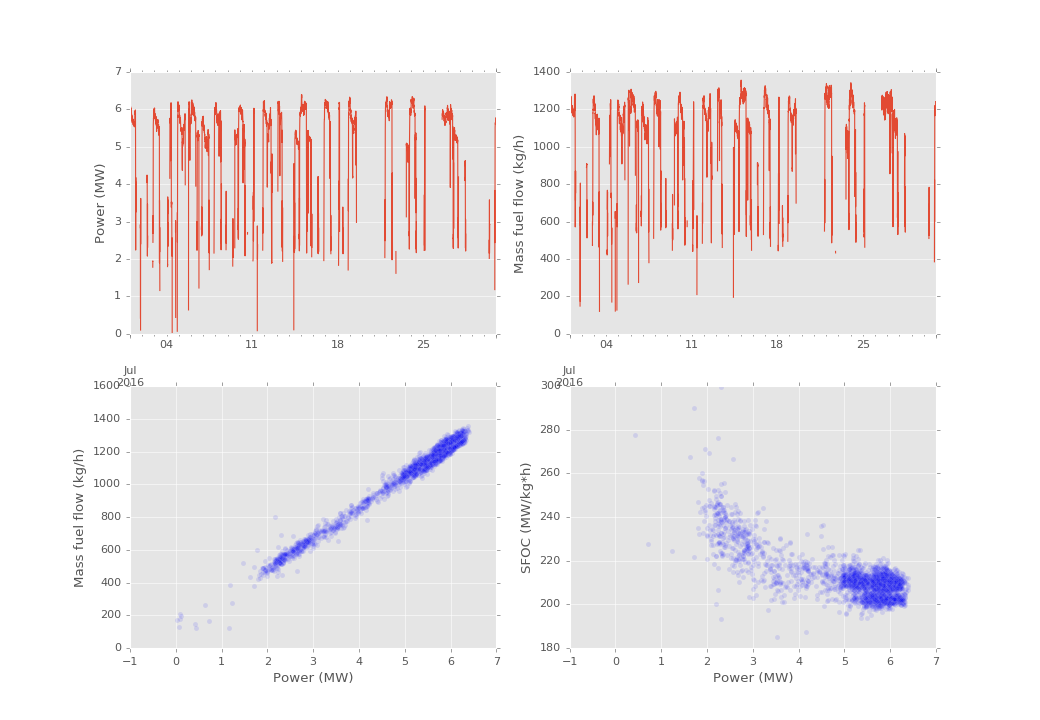

In [7]:
engine_no = '1'
validation.plot_diagnostic(sfoc_data_all,engine_no,begin_date=begin_date,end_date=end_date)

## Running the model

The following step fits a model to the data using the following parameters, based on the properties of the data shown above: the power range set by 'min_power' and 'max_power', and the resolution of the model set by 'step_power'. The 'fit_mode' parameter is defined as follows:

0: no fuel type separation, linear component only ('quick and dirty')

1: no fuel type separation, combines linear and non-linear components

2: fuel type separation, linear component only

3: fuel type separation, combines linear and non-linear components

We use fuel temperature and density data for fuel type separation when available. For Carnival ships, fuel type separation is done using temperature and density thresholds. For others, a KMeans clustering algorithm is used. When these data are not available fuel type separation is done using Agglomerative Clustering over normalized and scaled mass fuel flow and power data.

Mind you that fitting in modes 2 and 3 can take up to 30 minutes for all 6 engines.

In [8]:
engines = ['1']

min_power = 1.5
max_power = 7.0
step_power = 0.1

## Model validation

Let's now select the fitting mode and plot the results with the data.

Using temperature and density thresholds for fuel type split
Modeling engine 1


<IPython.core.display.Javascript object>


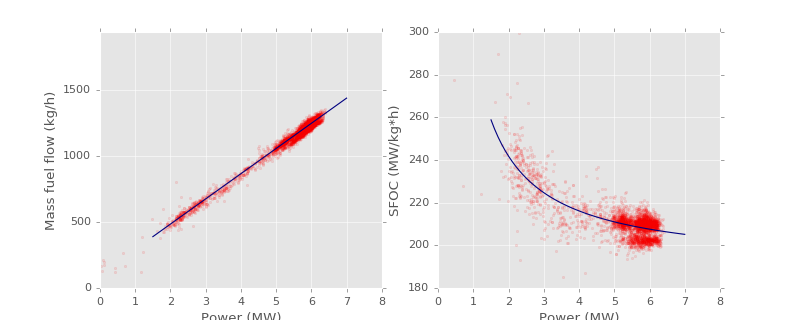

In [9]:
engine_no = '1'
fit_mode = 0
model,out_files,xgp = models.run(sfoc_data_all,ship,engines,begin_date,end_date,min_power,max_power,step_power,split=fit_mode)
validation.plot_model(sfoc_data_all,engine_no,model, xgp, split=fit_mode)

Using temperature and density thresholds for fuel type split
Modeling engine 1


<IPython.core.display.Javascript object>


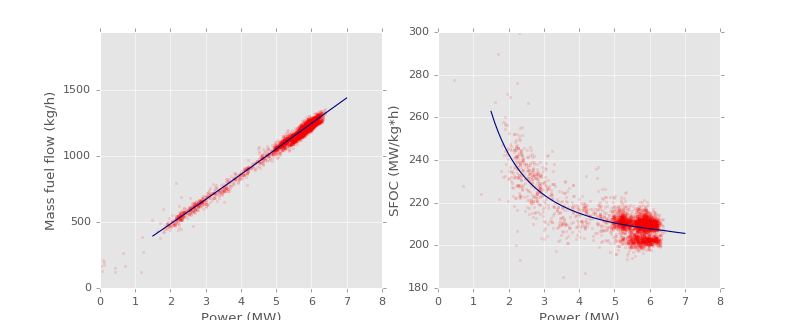

In [10]:
#engine_no = '1'
fit_mode = 1
model,out_files,xgp = models.run(sfoc_data_all,ship,engines,begin_date,end_date,min_power,max_power,step_power,split=fit_mode)
validation.plot_model(sfoc_data_all,engine_no,model, xgp, split=fit_mode)

Using temperature and density thresholds for fuel type split
Modeling engine 1
Fuel type split from clustering methods


/home/devvm/sfc17/sfc17/tools.py:227: RuntimeWarning: invalid value encountered in greater
  sfoc_data = sfoc_data[(sfoc_data['density.fuel.in@engine.main.'+engine_no].values > 500) & (sfoc_data['density.fuel.in@engine.main.'+engine_no].values < 1000)]
/home/devvm/sfc17/sfc17/tools.py:227: RuntimeWarning: invalid value encountered in less
  sfoc_data = sfoc_data[(sfoc_data['density.fuel.in@engine.main.'+engine_no].values > 500) & (sfoc_data['density.fuel.in@engine.main.'+engine_no].values < 1000)]


<IPython.core.display.Javascript object>


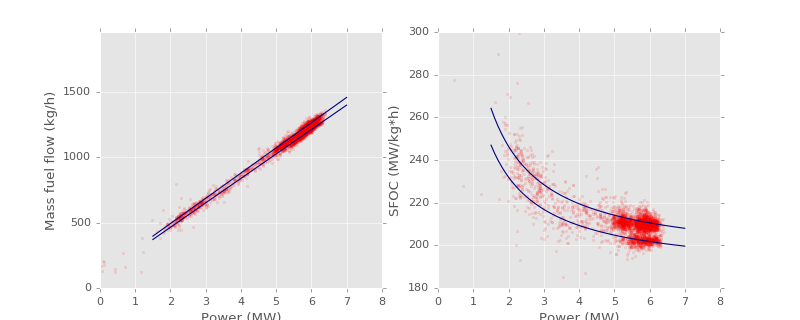

In [11]:
#engine_no = '1'
fit_mode = 2
model,out_files,xgp = models.run(sfoc_data_all,ship,engines,begin_date,end_date,min_power,max_power,step_power,split=fit_mode)
validation.plot_model(sfoc_data_all,engine_no,model, xgp, split=fit_mode)

Using temperature and density thresholds for fuel type split
Modeling engine 1
Fuel type split from clustering methods


/home/devvm/sfc17/sfc17/tools.py:227: RuntimeWarning: invalid value encountered in greater
  sfoc_data = sfoc_data[(sfoc_data['density.fuel.in@engine.main.'+engine_no].values > 500) & (sfoc_data['density.fuel.in@engine.main.'+engine_no].values < 1000)]
/home/devvm/sfc17/sfc17/tools.py:227: RuntimeWarning: invalid value encountered in less
  sfoc_data = sfoc_data[(sfoc_data['density.fuel.in@engine.main.'+engine_no].values > 500) & (sfoc_data['density.fuel.in@engine.main.'+engine_no].values < 1000)]


<IPython.core.display.Javascript object>


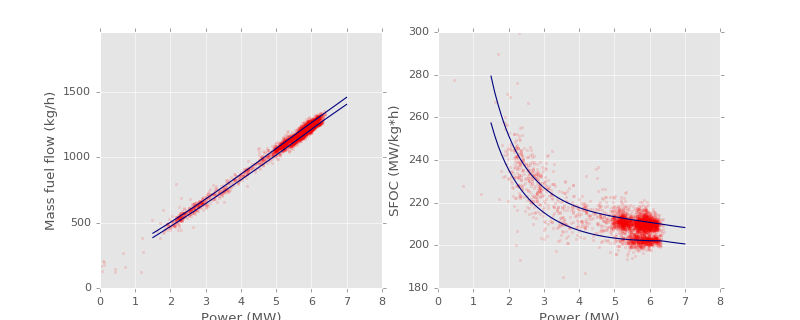

In [12]:
#engine_no = '1'
fit_mode = 3
model,out_files,xgp = models.run(sfoc_data_all,ship,engines,begin_date,end_date,min_power,max_power,step_power,split=fit_mode)
validation.plot_model(sfoc_data_all,engine_no,model, xgp, split=fit_mode)

In [13]:
model.head()

,model.ted.rig:sfc1@engine.main.1,model.ted.rig:sfc2@engine.main.1
0,279.306104,257.350568
1,272.079322,251.726272
2,265.961056,246.763659
3,260.576149,242.528908
4,255.758075,238.780678


## Generate JSON file(s)

In [14]:
tools.make_json(model,engines,xgp,ship,out_files,split=fit_mode)
#tools.make_json(model_2,xgp2,ship,out_file2)

In [ ]:
# import json
# from pprint import pprint

# with open('sfoc_1010-005_1.json') as data_file:    
#     data = json.load(data_file)

# pprint(data)

Loading data... engine 1


/home/devvm/sfc17/sfc17/tools.py:136: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sfoc_data_valid = sfoc_data_n[(sfoc_data['validator.aggregate:mode.ok{massFlowRate.fuel@engine.main.'+engines[j]+'}']==1)]
/home/devvm/sfc17/sfc17/tools.py:227: RuntimeWarning: invalid value encountered in greater
  sfoc_data = sfoc_data[(sfoc_data['density.fuel.in@engine.main.'+engine_no].values > 500) & (sfoc_data['density.fuel.in@engine.main.'+engine_no].values < 1000)]
/home/devvm/sfc17/sfc17/tools.py:227: RuntimeWarning: invalid value encountered in less
  sfoc_data = sfoc_data[(sfoc_data['density.fuel.in@engine.main.'+engine_no].values > 500) & (sfoc_data['density.fuel.in@engine.main.'+engine_no].values < 1000)]


Fuel type split from clustering methods


/home/devvm/sfc17/sfc17/validation.py:307: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sfoc_data_range_0['sfc'] = sfc_range1.values
/home/devvm/sfc17/sfc17/validation.py:309: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sfoc_data_range_1['sfc'] = sfc_range2.values


<IPython.core.display.Javascript object>


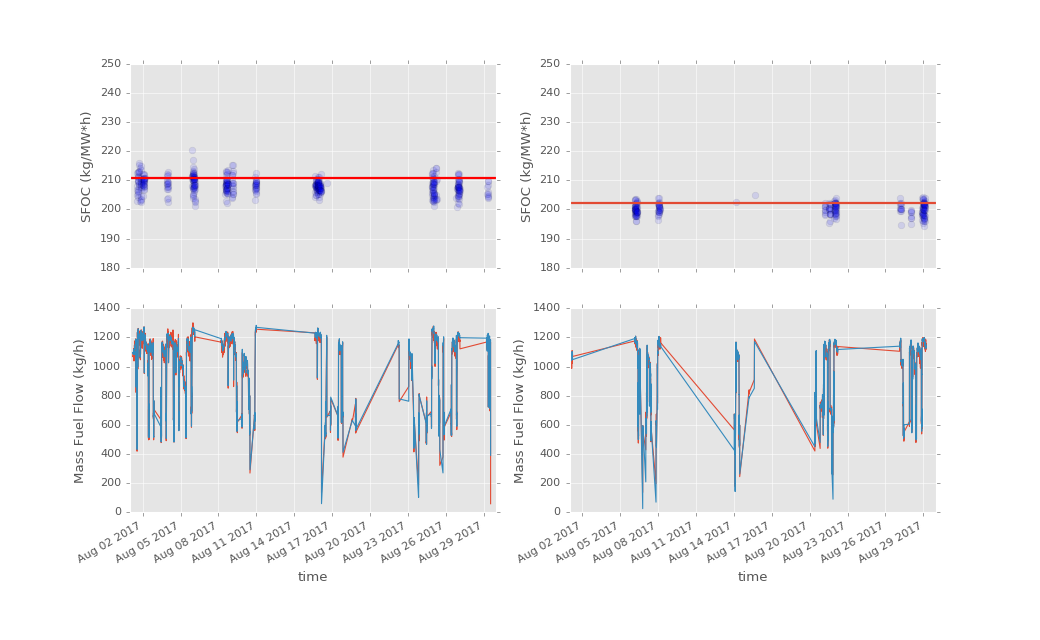

In [15]:
begin_date_2 = '2017-08-01'
end_date_2 = '2017-08-30'
#j=0
validation.comparison_sfc_plot(engine_no,ship,begin_date_2,end_date_2, gd, model, xgp, fit_mode,sfoc_plc,decomp=decomp)

## Current developments

- Deriving mass fuel flow from volume fuel flow
- Jenkins integration
- Nose tests
- Documentation

In [16]:
df_fit = ff_decomposition.decomp_fit(ship,begin_date, end_date)

No volume flow rate data available to decompose.
